In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re #Stopwords
import nltk #PortStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')
# Add labels to the datasets
fake_df['label'] = 0
true_df['label'] = 1

# Combine the datasets
# news_df = pd.concat([fake_df, true_df], ignore_index=True)



# Define a function to preprocess the text data
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text.lower())  # Remove non-word characters and convert to lowercase
    words = text.split()
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word not in set(stopwords.words('english'))]  # Remove stopwords and lemmatize
    return ' '.join(words)

# Preprocess the text data for both fake_df and true_df
fake_df['processed_text'] = fake_df['text'].apply(preprocess_text)
true_df['processed_text'] = true_df['text'].apply(preprocess_text)

# Preprocess the text data
# news_df['processed_text'] = news_df['text'].apply(preprocess_text)
# Combine the datasets
news_df = pd.concat([fake_df, true_df], ignore_index=True)


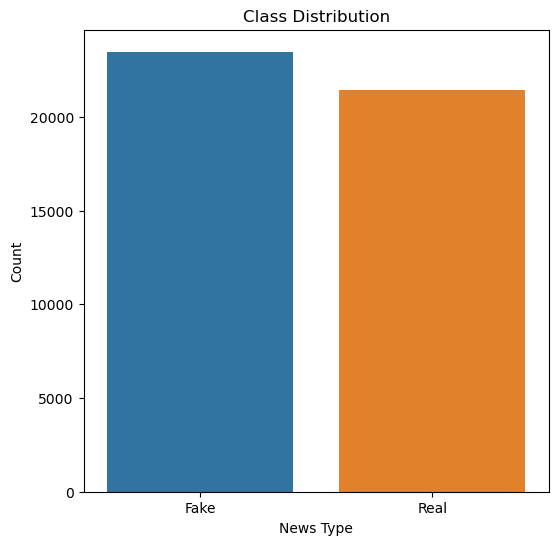

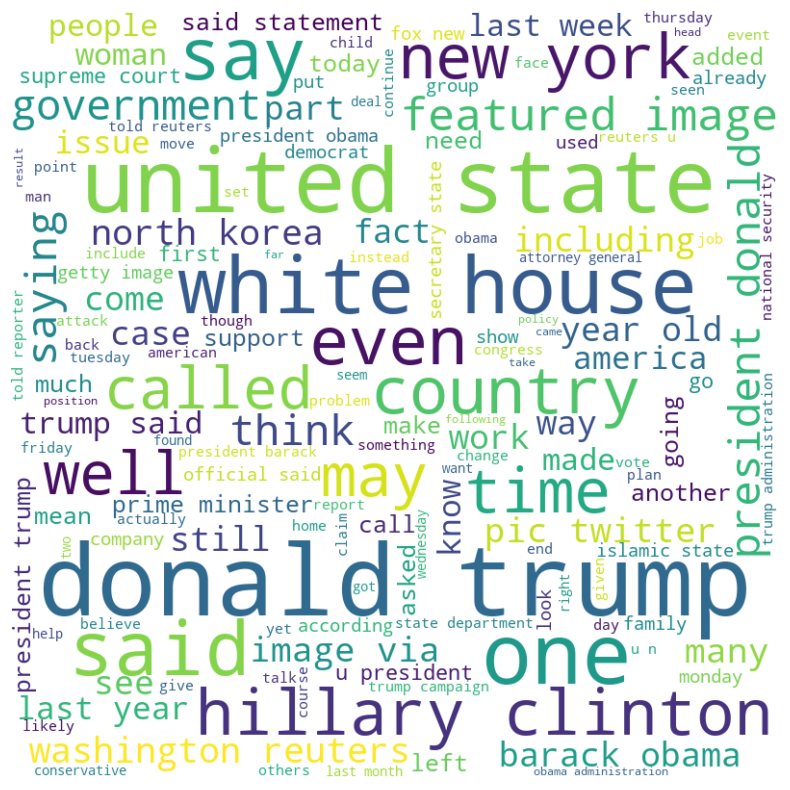

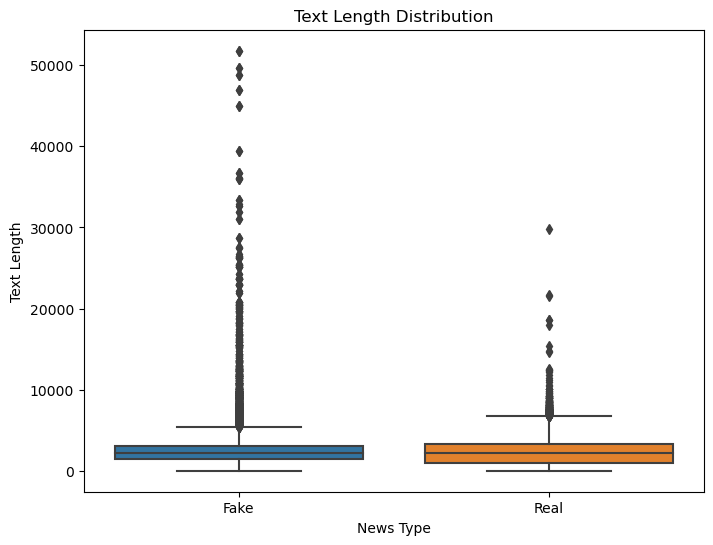

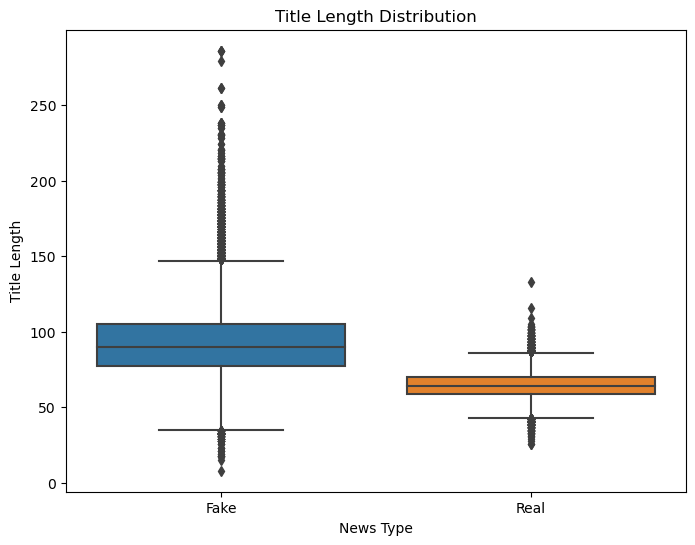

In [10]:
"""
Visualize the class distribution
"""
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=news_df)
plt.xlabel('News Type')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()




"""
Word Cloud
"""
# Combine all processed text
all_text = ' '.join(news_df['processed_text'].values)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=150).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

"""
Box Plot for Text/Title Lengths
"""
news_df['text_length'] = news_df['text'].apply(len)
news_df['title_length'] = news_df['title'].apply(len)
# Box plot for text lengths
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='text_length', data=news_df)
plt.xlabel('News Type')
plt.ylabel('Text Length')
plt.title('Text Length Distribution')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

# Box plot for title lengths
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='title_length', data=news_df)
plt.xlabel('News Type')
plt.ylabel('Title Length')
plt.title('Title Length Distribution')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


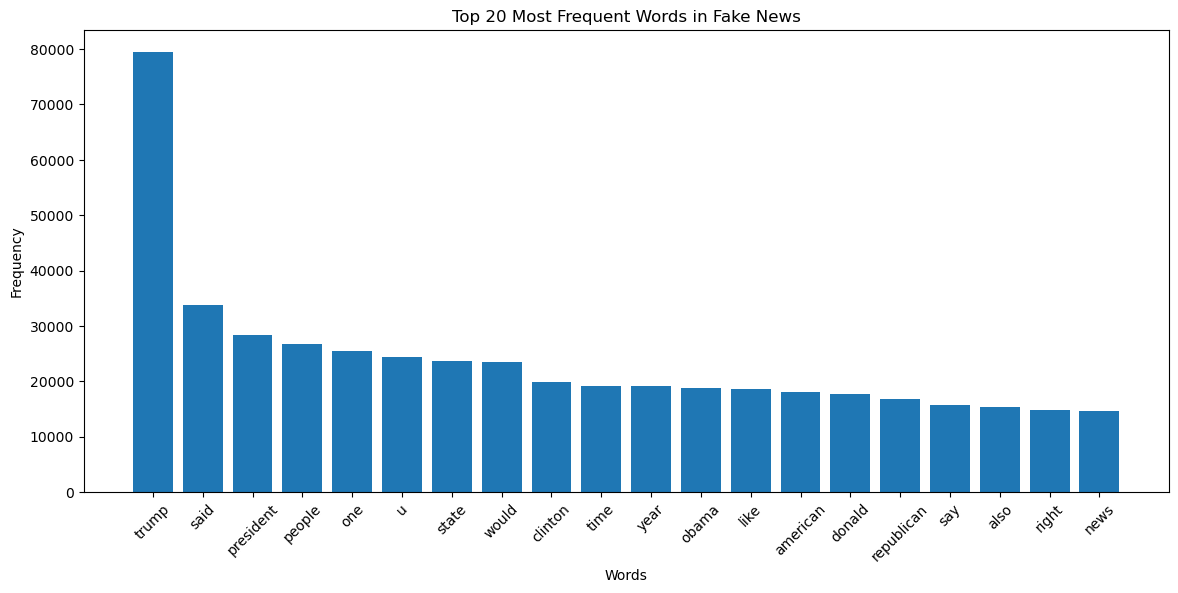

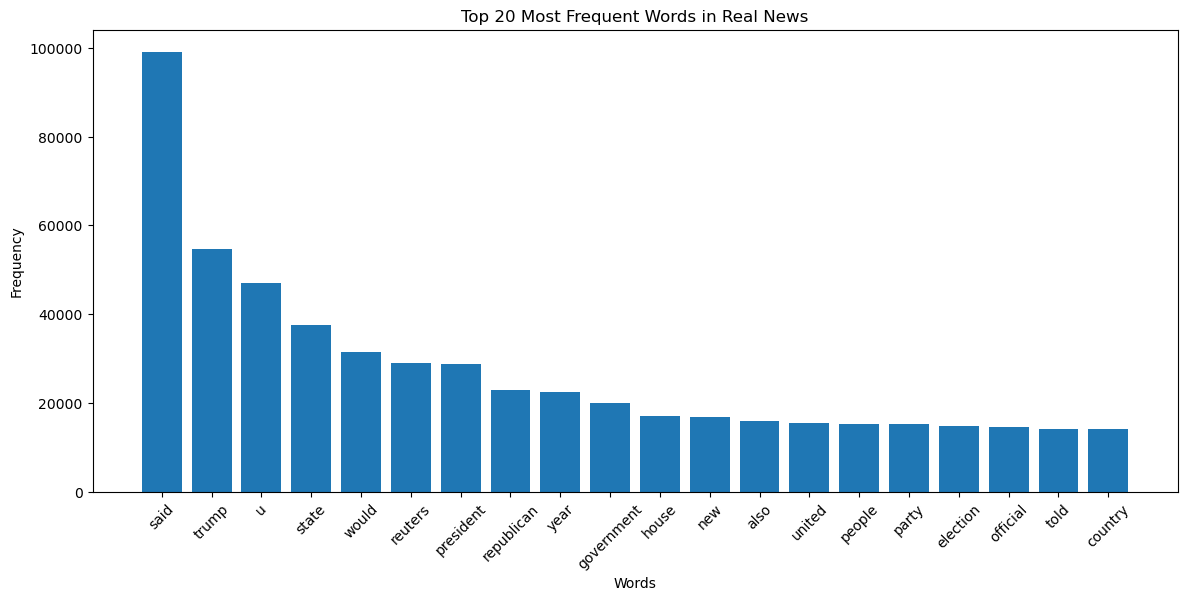

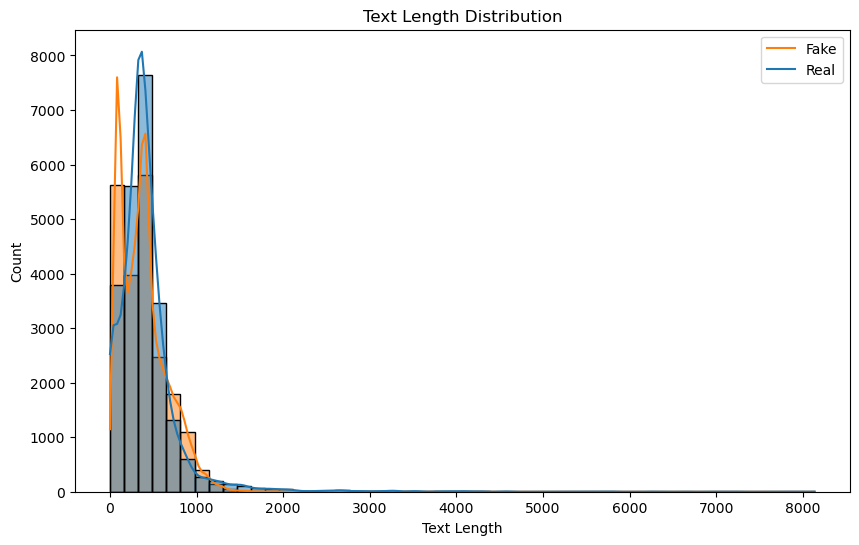

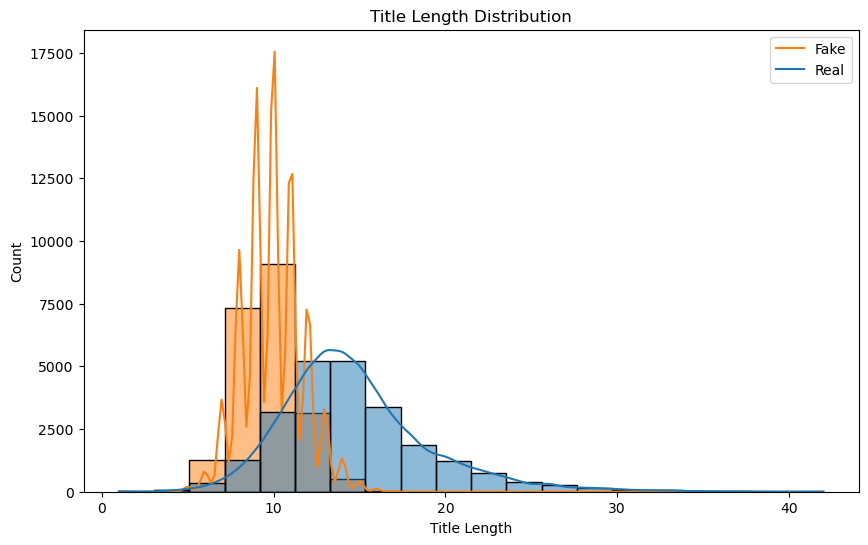

In [11]:
"""
Visualize the most frequent words
"""
def get_most_common_words(df, n=20):
    all_text = ' '.join(df['processed_text'].values)
    words = all_text.split()
    most_common_words = Counter(words).most_common(n)
    return most_common_words

def plot_most_common_words(most_common_words, title):
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(14, 6))
    plt.bar(words, counts)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Most frequent words in fake news
most_common_fake_words = get_most_common_words(fake_df, n=20)
plot_most_common_words(most_common_fake_words, 'Top 20 Most Frequent Words in Fake News')

# Most frequent words in real news
most_common_real_words = get_most_common_words(true_df, n=20)
plot_most_common_words(most_common_real_words, 'Top 20 Most Frequent Words in Real News')

"""
Visualize text length distribution
"""
# Add a column for text length
news_df['text_length'] = news_df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=news_df, x='text_length', hue='label', kde=True, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Text Length Distribution')
plt.legend(labels=['Fake', 'Real'])
plt.show()

"""
Visualize title length distribution
"""
# Add a column for title length
news_df['title_length'] = news_df['title'].apply(lambda x: len(x.split()))

# Plot the distribution of title lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=news_df, x='title_length', hue='label', kde=True, bins=20)
plt.xlabel('Title Length')
plt.ylabel('Count')
plt.title('Title Length Distribution')
plt.legend(labels=['Fake', 'Real'])
plt.show()

In [8]:
# Split the dataset into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(news_df['processed_text'], news_df['label'], test_size=0.2, random_state=42)

# Split the train set further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2



In [9]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [10]:
# Define a function to evaluate the models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

# Create a hyperparameter grid for Logistic Regression
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
# Create a hyperparameter grid for Support Vector Machines
svc_param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
# Create a hyperparameter grid for Naïve Bayes
nb_param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10]}    

# Instantiate the models
lr_model = LogisticRegression(max_iter=1000)
svc_model = SVC(max_iter=1000)
nb_model = MultinomialNB()

# Create GridSearchCV instances
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy')
svc_grid_search = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='accuracy')
nb_grid_search = GridSearchCV(nb_model, nb_param_grid, cv=5, scoring='accuracy')

# Perform the grid search for Logistic Regression
lr_grid_search.fit(X_train_tfidf, y_train)
# Perform the grid search for Support Vector Machines
svc_grid_search.fit(X_train_tfidf, y_train)
# Perform the grid search for Naïve Bayes
nb_grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for Logistic Regression
print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)
# Print the best hyperparameters for Support Vector Machines
print("Best parameters for Support Vector Machines:", svc_grid_search.best_params_)
# Print the best hyperparameters for Naïve Bayes
print("Best parameters for Naïve Bayes:", nb_grid_search.best_params_)



# Evaluate the best models on the validation set
print("\nEvaluating the best models on the validation set:")
print("\nLogistic Regression")
best_lr_model = lr_grid_search.best_estimator_
evaluate_model(best_lr_model, X_train_tfidf, X_val_tfidf, y_train, y_val)

print("\nSupport Vector Machines")
best_svc_model = svc_grid_search.best_estimator_
evaluate_model(best_svc_model, X_train_tfidf, X_val_tfidf, y_train, y_val)

print("\nNaïve Bayes")
best_nb_model = nb_grid_search.best_estimator_
evaluate_model(best_nb_model, X_train_tfidf, X_val_tfidf, y_train, y_val)

# Evaluate the best model (assume the best model is Logistic Regression) on the test set

# print("\nEvaluating the best model on the test set:")
# evaluate_model(best_lr_model, X_train_tfidf, X_test_tfidf, y_train, y_test)


    

    
# Logistic Regression
# print("Logistic Regression")
# lr_model = LogisticRegression()
# evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

# # Naïve Bayes
# print("\nNaïve Bayes")
# nb_model = MultinomialNB()
# evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

# # Support Vector Machines
# print("\nSupport Vector Machines")
# svc_model = SVC()
# evaluate_model(svc_model, X_train_tfidf, X_test_tfidf, y_train, y_test)


C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1

Best parameters for Logistic Regression: {'C': 100}
Best parameters for Support Vector Machines: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best parameters for Naïve Bayes: {'alpha': 0.01}

Evaluating the best models on the validation set:

Logistic Regression
Accuracy: 0.9917594654788419
Precision: 0.9930635838150289
Recall: 0.9898594146116617
F1 Score: 0.9914589104339797
Confusion Matrix: [[4611   30]
 [  44 4295]]

Support Vector Machines


C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.9924276169265034
Precision: 0.9930731932579081
Recall: 0.9912422217100715
F1 Score: 0.9921568627450981
Confusion Matrix: [[4611   30]
 [  38 4301]]

Naïve Bayes
Accuracy: 0.9439866369710468
Precision: 0.9500234631628344
Recall: 0.9331643235768611
F1 Score: 0.941518428089757
Confusion Matrix: [[4428  213]
 [ 290 4049]]


Evaluating Logistic Regression on the validation set:


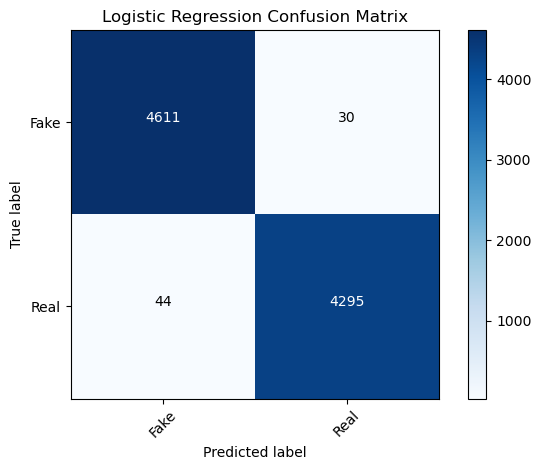

Evaluating Support Vector Machines on the validation set:


C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


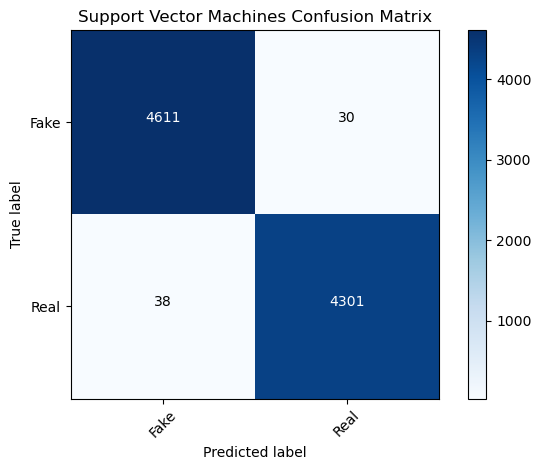

Evaluating Naïve Bayes on the validation set:


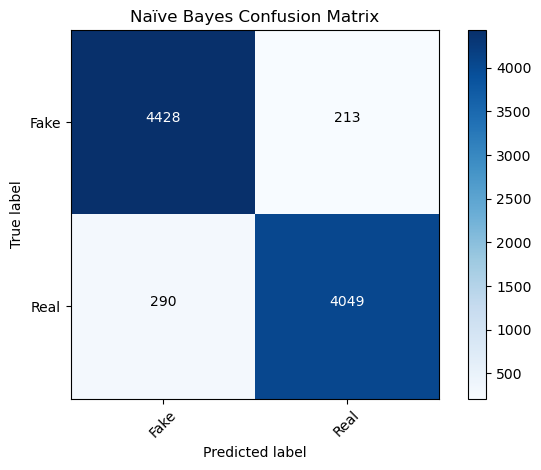

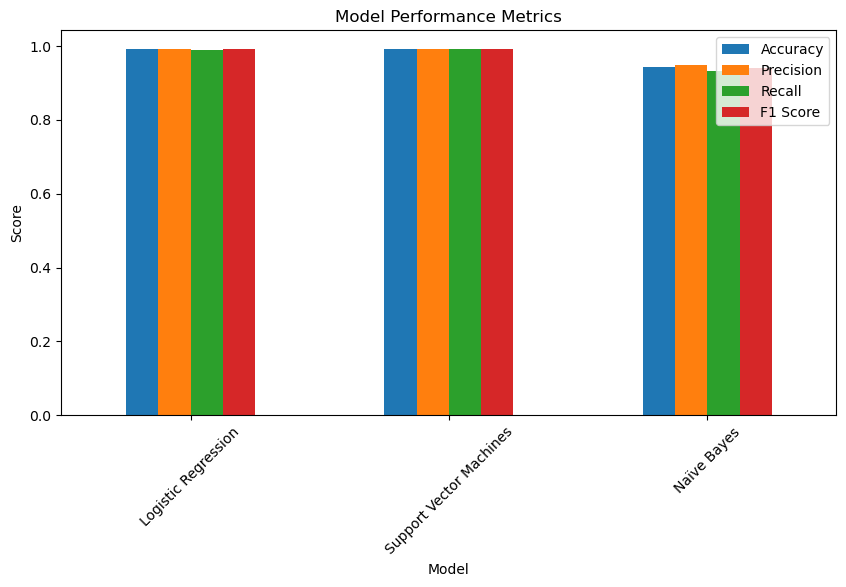

In [11]:
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_model_performance(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Fake', 'Real'], title=f'{model_name} Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Evaluate the best models on the validation set
best_models = [best_lr_model, best_svc_model, best_nb_model]
model_names = ['Logistic Regression', 'Support Vector Machines', 'Naïve Bayes']

performance_metrics = []
for model, model_name in zip(best_models, model_names):
    print(f"Evaluating {model_name} on the validation set:")
    metrics = plot_model_performance(model, X_train_tfidf, X_val_tfidf, y_train, y_val, model_name)
    performance_metrics.append(metrics)

# Create a DataFrame of model performance metrics
performance_df = pd.DataFrame(performance_metrics)

# Plot a bar chart of model performance metrics
performance_df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1 Score'], kind='bar', figsize=(10, 5))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Assuming Logistic Regression was the best-performing model
feature_names = np.array(CountVectorizer.get_feature_names_out())
sorted_coef_index = lr_model.coef_[0].argsort()

# Top 10 features for fake news
print('Top 10 features for fake news:')
print(feature_names[sorted_coef_index[:10]])

# Top 10 features for real news
print('\nTop 10 features for real news:')
print(feature_names[sorted_coef_index[-10:]])


TypeError: get_feature_names_out() missing 1 required positional argument: 'self'